#Load Packages

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.linear_model import LinearRegression
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import median_filter

In [78]:
!pip install pmdarima
!pip install prophet

#Introduction

We will use over 80 years of daily sea surface temperature, wave height, and wind speed data from seven major ocean basins: the Arctic, North Atlantic, South Atlantic, Indian, North Pacific, South Pacific, and Southern Oceans. We will examine these time series for evidence of long-term trends such as warming ocean temperatures and more frequent or intense storms. In this notebook, we will be looking at the 'south pacific' data set specifically.

#The Data

We will use data queried from the ERA5 Reanalysis ProductLinks, https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview, to an external site.. A reanalysis is a dataset that combines historical observations (which we trust within the uncertainty of the instrument used to make the measurement, but cannot feasibly cover the entire world) with a physics-based computer model of the earth system (which is not generally as accurate as a measurement, but can at least cover the entire world) to produce consistent global datasets of all variables we are interested in. ERA5 is produced by the European Center for Medium-Range Weather Forecasting (ECMWF), widely regarded as the best forecasting center in the world. Therefore, it is the preferred data product for studying how the Earth's climate has evolved over the past century.

In [79]:
south_pacific = pd.read_csv('https://raw.githubusercontent.com/nrg-frogusa/Climate-Change/main/south_pacific.csv')

These are all the data that we'll be basing our analysis on.

We'll take a quick look at the data within each set to get a better idea of what we're looking at.

In [80]:
south_pacific.head()

,sst,u10,hsig,time,latitude,longitude
0,291.74900,1.479218,2.039036,1940-01-01 12:00:00,-35.0,-165.0
1,291.80466,0.636111,1.567293,1940-01-02 12:00:00,-35.0,-165.0
2,291.85544,3.894659,1.214057,1940-01-03 12:00:00,-35.0,-165.0
3,291.90817,3.991070,2.437233,1940-01-04 12:00:00,-35.0,-165.0
4,291.95996,2.706026,2.678540,1940-01-05 12:00:00,-35.0,-165.0


In [81]:
south_pacific.info()
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30741 entries, 0 to 30740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sst        30741 non-null  float64
 1   u10        30741 non-null  float64
 2   hsig       30741 non-null  float64
 3   time       30741 non-null  object 
 4   latitude   30741 non-null  float64
 5   longitude  30741 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


# Guiding Question

I want to provide a guiding question to inform my analysis in a more specific manner.

Question: What is the long-term ocean warming trend of all data sets? And if it's indicative of future temperatures, what can we expect/predict temperatures will look like in 20 years?

# Analysis

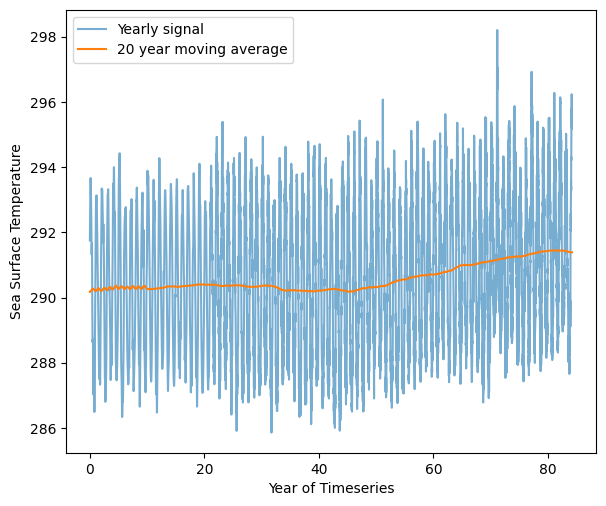

In [82]:
df = south_pacific
sst = df["sst"].values
t = np.arange(len(sst))

# 20 year moving average
window_len = 365 * 20
sst_ma = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, sst, alpha=0.6, label="Yearly signal")
ax.plot(t / 365, sst_ma, label="20 year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Sea Surface Temperature")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

Here we can see that the moving average for sea surface temperature has risen by a slight margin over the past 80 years. The moving average seems to be accerlerating around the 45 year mark, maintaining its momentum throug the 60 year mark. This is a good section of time to forecast into the future to determine whether there is acceleration in the warming of sea surface temperature.

In [107]:
sst = sst.reshape(-1, 1)
# The time units are in days so the 'k' value is 20 * 365 to get a 20-year time lag to forecast 20 years into the future.
k = 7300

first_half = range(len(sst) // 2)
second_half = range(len(sst) // 2, len(sst))

train_indices = list(first_half)
test_indices = list(second_half)

sst_train = sst[train_indices, :]
sst_test = sst[test_indices, :]

sst_predictor_train = sst_train[:-k, :]
sst_response_train = sst_train[k:, :]

sst_predictor_test = sst_test[:-k, :]
sst_response_test = sst_test[k:, :]

reg = LinearRegression().fit(sst_predictor_train, sst_response_train)
sst_predicted = reg.predict(sst_predictor_test)
mae = np.nanmean(np.abs(sst_predicted - sst_response_test))

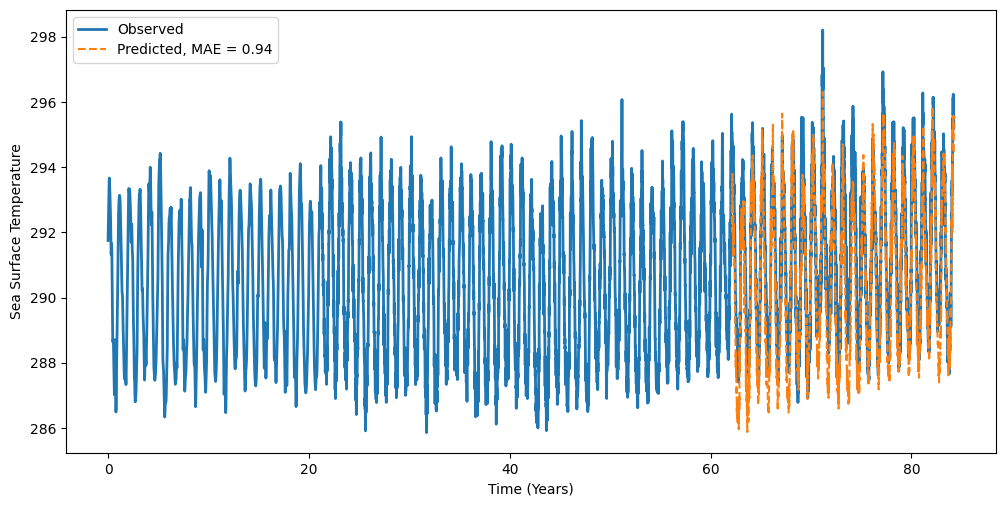

In [109]:
fig, ax = plt.subplots()
# Divided 't' by 365 to display the year insntead of days.
ax.plot(t / 365, sst, '-', linewidth=2, label="Observed")
ax.plot(t[test_indices[k:]] / 365, sst_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (Years)")
ax.set_ylabel("Sea Surface Temperature")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

From our analysis, we can be reasonably confident that the sea surface temperatures will be different than the past 20 years. We predict that there will be differences through the MAE being 0.94 degrees. From looking at the peaks and valleys, it seems like there will be less variation in temperatures from season-to-season and year-to-year, especially on the upper end of the plot. This may indicate that the summers will be less extreme/hot and winters will be colder. I'm not sure as to the accuracy of the prediction model, but these are the results I got.

# Additional Question

This analysis also answers the question: Is ocean warming accelerating?

The lower 'highs' and lower 'lows' indicate that the sea surface temperature is not accelerating and decelerating if anything. Even though the sea surface temperature is positively correlated to atmosphere temperature, we cannot diffinitively claim whether or not atmosphere temperature will follow suit.